In [1]:
# !pip install catboost
# !pip3 install imblearn

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import itertools

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler                          
from sklearn.metrics import roc_auc_score, f1_score, silhouette_score, homogeneity_score,\
completeness_score, v_measure_score, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

pd.set_option('display.max_rows', 1000) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

from catboost import CatBoostClassifier, Pool, cv
from xgboost import XGBClassifier as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

In [3]:
RANDOM_STATE =42
np.random.seed(RANDOM_STATE)
labels=["Норма","Прихват"]

In [4]:
metrics = {
    'precision': [],
    'recall': []
}
for i in range(1, 6):
    path = r'C:\Users\shers\Desktop\SF\Буровая\cross_val_pred_30\fold_' + str(i) +\
    '\StuckPipe_train'
        
    %load_ext autoreload
    %autoreload 1
    %aimport reading_data
    reading_data.walk_dir(path)
        
    data = pd.read_csv('data.csv')
#     X =data[[
#         'GR', 'SPPA_APRS', 'ECD', 'APRS', 'RPM', 'FLWI','STOR', 'BPOS', 'SPPA',
#         'DDEPT_3', 'DDEPT_6', 'conner', 'F', 'PDEPT', 'DBPOS_3','DBPOS_6',  'DEPT'
#              ]].values
    X =data[[
#          'F', 'STOR', 'SPPA_APRS', 'FSTOR_3', 'HKLD_bin_new',
#          'DSPPA_3', 'BVEL_bin', 
#          'DSPPA_18', 'DSPPA_6', 'FDEPT_3', 'ANOMAL', 'DBPOS_6', 'DBVEL_6', 'HKLD', 'DBVEL_12', 
#          'DHKLD_12', 'DBVEL_18', 'FBPOS_3', 'DRPM', 'RPM', 'SPPA_APRS_back1', 'ESD', 'FSPPA_3', 
#          'DSTOR_18', 'DSPPA_12', 'BPOS', 'FLWI', 'DBPOS_18', 'FHKLD_3', 'DSPPA_APRS_3', 'DBVEL_3', 
#          'DDEPT_18', 'DRPM_18', 'ECD', 'PDEPT', 'DSTOR_12', 'FSPPA_APRS_3', 'SPPA', 'DHKLD_18',
#          'DHKLD_6', 'DSPPA', 'DEPT', 'F_all', 'DBPOS_12'
        'DEPT', 'HDTH', 'BPOS', 'HKLD', 'STOR', 'FLWI', 'RPM',
        'SPPA', 'ECD', 'DLS', 'INCL', 'AZIM', 'GR', 'APRS', 'BVEL', 'RIG_STATE',
        'ESD', 'Stick', 'DDEPT_1', 'DDEPT_3', 'DDEPT',
        'DDEPT_6', 'DDEPT_12', 'DDEPT_18', 'DBPOS', 'DBPOS_1', 'DBPOS_3',
        'DBPOS_6', 'DBPOS_12', 'DBPOS_18', 'DHKLD', 'DHKLD_1', 'DHKLD_3', 'DHKLD_6', 
        'DHKLD_12', 'DHKLD_18', 'DSPPA', 'DSPPA_1',
        'DSPPA_3', 'DSPPA_6', 'DSPPA_12', 'DSPPA_18',
        'DRPM', 'DRPM_1', 'DRPM_3', 'DRPM_6', 'DRPM_12', 'DRPM_18', 
        'DBVEL', 'DBVEL_1', 'DBVEL_3', 'DBVEL_6', 'FBVEL_1', 'DBVEL_12', 'DBVEL_18',
        'DSTOR_1', 'DSTOR_3', 'DSTOR_6', 'DSTOR_12', 'DSTOR_18',
        'SPPA_APRS', 'DSPPA_APRS_1', 'DSPPA_APRS_3', 'DSPPA_APRS_6',
        'DSPPA_APRS_12', 'DSPPA_APRS_18', 'DECD', 'ANOMAL',
        'discardSPPA', 'discardSTOR', 'discardECD', 'discardStick', 'discardAPRS', 'discardRPM',
        'PDEPT', 'F', 'F_all', 'conner', 'conner_delta', 'GR_type',
        'DEPT_back3', 'SPPA_back3', 'SPPA_APRS_back3',
        'BVEL_back3', 'HKLD_back3', 'BPOS_back3', 
        'RPM_back3', 'STOR_back3', 'DEPT_back1', 'SPPA_back1', 'SPPA_APRS_back1',
        'BVEL_back1', 'HKLD_back1', 'BPOS_back1', 
        'RPM_back1', 'STOR_back1'
    ]].values 
    
#     # нормализация:
#     sc = StandardScaler()    # MaxAbsScaler- StandardScaler+ RobustScaler+
#     X = sc.fit_transform(X)
    y = data['StuckPipe'].values
    
    X_train = X[0:23000]
    X_val = X[23000:]
    y_train = y[0:23000]
    y_val = y[23000:]
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, shuffle=False, random_state=RANDOM_STATE)
    
#     X, y = SMOTE(random_state=RANDOM_STATE).fit_resample(X, y)
#     classes = np.unique(y_train)
#     weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
#     class_weights = dict(zip(classes, weights))
#     model = XGBClassifier(learning_rate=0.01, 
#                            penalty='l1',
#                            class_weight= {0:1, 1:5},
#                            n_estimators=1000, max_depth=9)
    model = CatBoostClassifier(iterations=4000,
                        depth=9,
                        learning_rate=0.001,
                        #custom_loss=['Accuracy'],
                        loss_function='Logloss', 
                        class_weights={0:1, 1:5},
#                         class_weights=class_weights,
#                         auto_class_weights='Balanced',
                        eval_metric='Accuracy',
#                         l2_leaf_reg=1,
                        verbose=True, 
                        use_best_model=True,
                        task_type='CPU')
    
#     model.fit(X, y)
    model.fit(X_train, y_train, eval_set = (X_val, y_val), 
          early_stopping_rounds=500)
    
    path = r'C:\Users\shers\Desktop\SF\Буровая\cross_val_pred_30\fold_' + str(i) +\
    '\StuckPipe_test'
    
    %load_ext autoreload
    %autoreload 1
    %aimport reading_data
    reading_data.walk_dir(path)
    
    data = pd.read_csv('data.csv')
    
#     X =data[[
#         'GR', 'SPPA_APRS', 'ECD', 'APRS', 'RPM', 'FLWI','STOR', 'BPOS', 'SPPA',
#         'DDEPT_3', 'DDEPT_6', 'conner', 'F', 'PDEPT', 'DBPOS_3','DBPOS_6',  'DEPT'
#              ]].values 
    X =data[[
#          'F', 'STOR', 'SPPA_APRS', 'FSTOR_3', 'HKLD_bin_new',
#          'DSPPA_3', 'BVEL_bin', 
#          'DSPPA_18', 'DSPPA_6', 'FDEPT_3', 'ANOMAL', 'DBPOS_6', 'DBVEL_6', 'HKLD', 'DBVEL_12', 
#          'DHKLD_12', 'DBVEL_18', 'FBPOS_3', 'DRPM', 'RPM', 'SPPA_APRS_back1', 'ESD', 'FSPPA_3', 
#          'DSTOR_18', 'DSPPA_12', 'BPOS', 'FLWI', 'DBPOS_18', 'FHKLD_3', 'DSPPA_APRS_3', 'DBVEL_3', 
#          'DDEPT_18', 'DRPM_18', 'ECD', 'PDEPT', 'DSTOR_12', 'FSPPA_APRS_3', 'SPPA', 'DHKLD_18',
#          'DHKLD_6', 'DSPPA', 'DEPT', 'F_all', 'DBPOS_12'
        'DEPT', 'HDTH', 'BPOS', 'HKLD', 'STOR', 'FLWI', 'RPM',
        'SPPA', 'ECD', 'DLS', 'INCL', 'AZIM', 'GR', 'APRS', 'BVEL', 'RIG_STATE',
        'ESD', 'Stick', 'DDEPT_1', 'DDEPT_3', 'DDEPT',
        'DDEPT_6', 'DDEPT_12', 'DDEPT_18', 'DBPOS', 'DBPOS_1', 'DBPOS_3',
        'DBPOS_6', 'DBPOS_12', 'DBPOS_18', 'DHKLD', 'DHKLD_1', 'DHKLD_3', 'DHKLD_6', 
        'DHKLD_12', 'DHKLD_18', 'DSPPA', 'DSPPA_1',
        'DSPPA_3', 'DSPPA_6', 'DSPPA_12', 'DSPPA_18',
        'DRPM', 'DRPM_1', 'DRPM_3', 'DRPM_6', 'DRPM_12', 'DRPM_18', 
        'DBVEL', 'DBVEL_1', 'DBVEL_3', 'DBVEL_6', 'FBVEL_1', 'DBVEL_12', 'DBVEL_18',
        'DSTOR_1', 'DSTOR_3', 'DSTOR_6', 'DSTOR_12', 'DSTOR_18',
        'SPPA_APRS', 'DSPPA_APRS_1', 'DSPPA_APRS_3', 'DSPPA_APRS_6',
        'DSPPA_APRS_12', 'DSPPA_APRS_18', 'DECD', 'ANOMAL',
        'discardSPPA', 'discardSTOR', 'discardECD', 'discardStick', 'discardAPRS', 'discardRPM',
        'PDEPT', 'F', 'F_all', 'conner', 'conner_delta', 'GR_type',
        'DEPT_back3', 'SPPA_back3', 'SPPA_APRS_back3',
        'BVEL_back3', 'HKLD_back3', 'BPOS_back3', 
        'RPM_back3', 'STOR_back3', 'DEPT_back1', 'SPPA_back1', 'SPPA_APRS_back1',
        'BVEL_back1', 'HKLD_back1', 'BPOS_back1', 
        'RPM_back1', 'STOR_back1'
    ]].values 
    
#     X = sc.fit_transform(X)
    y_pred = data['StuckPipe'].values

    predict_cat = model.predict_proba(X)
    df=pd.DataFrame()
    df = pd.DataFrame((_ for _ in itertools.zip_longest(*predict_cat))).T
    df.rename(columns = {0:'predict', 1:'Predict'}, inplace = True)
    df['mark'] = 0
    df.loc[df['Predict'] > 0.5, 'mark'] = 1
    predict_list = df['mark'].tolist()
    
#     for i in range(len(predict_list)-4):
#         if predict_list[i]==0 and predict_list[i-1]==1 and predict_list[i+1]==1:
#             predict_list[i]=1
#         if predict_list[i]==0 and predict_list[i-1]==1 and predict_list[i+2]==1:
#             predict_list[i]=1
    
#         if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+1]==0:
#             predict_list[i]=0
#         if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+2]==0:
#             predict_list[i]=0
#         if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+3]==0:
#             predict_list[i]=0
#     if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+4]==0:
#         predict_list[i]=0
      
    
    rec = recall_score(y_pred, predict_list)
    pres = precision_score(y_pred, predict_list)
    
    metrics['precision'].append(pres)
    metrics['recall'].append(rec)

0:	learn: 0.8808954	test: 0.8436774	best: 0.8436774 (0)	total: 486ms	remaining: 32m 22s
1:	learn: 0.8992164	test: 0.8450050	best: 0.8450050 (1)	total: 867ms	remaining: 28m 53s
2:	learn: 0.9053113	test: 0.8516429	best: 0.8516429 (2)	total: 1.26s	remaining: 28m 3s
3:	learn: 0.9044406	test: 0.8503153	best: 0.8516429 (2)	total: 1.61s	remaining: 26m 46s
4:	learn: 0.9052750	test: 0.8473282	best: 0.8516429 (2)	total: 1.95s	remaining: 25m 57s
5:	learn: 0.9054927	test: 0.8539661	best: 0.8539661 (5)	total: 2.27s	remaining: 25m 14s
6:	learn: 0.9066173	test: 0.8503153	best: 0.8539661 (5)	total: 2.63s	remaining: 24m 58s
7:	learn: 0.9071252	test: 0.8489877	best: 0.8539661 (5)	total: 2.96s	remaining: 24m 38s
8:	learn: 0.9070527	test: 0.8562894	best: 0.8562894 (8)	total: 3.31s	remaining: 24m 28s
9:	learn: 0.9072704	test: 0.8559575	best: 0.8562894 (8)	total: 3.65s	remaining: 24m 14s
10:	learn: 0.9103178	test: 0.8576170	best: 0.8576170 (10)	total: 4s	remaining: 24m 10s
11:	learn: 0.9113336	test: 0.85562

92:	learn: 0.9116964	test: 0.8589446	best: 0.8612678 (20)	total: 30.8s	remaining: 21m 33s
93:	learn: 0.9114787	test: 0.8589446	best: 0.8612678 (20)	total: 31.1s	remaining: 21m 32s
94:	learn: 0.9116601	test: 0.8589446	best: 0.8612678 (20)	total: 31.4s	remaining: 21m 31s
95:	learn: 0.9116601	test: 0.8586127	best: 0.8612678 (20)	total: 31.7s	remaining: 21m 30s
96:	learn: 0.9115876	test: 0.8582808	best: 0.8612678 (20)	total: 32s	remaining: 21m 28s
97:	learn: 0.9118778	test: 0.8599403	best: 0.8612678 (20)	total: 32.3s	remaining: 21m 27s
98:	learn: 0.9122043	test: 0.8602722	best: 0.8612678 (20)	total: 32.7s	remaining: 21m 26s
99:	learn: 0.9122043	test: 0.8602722	best: 0.8612678 (20)	total: 33s	remaining: 21m 26s
100:	learn: 0.9123857	test: 0.8599403	best: 0.8612678 (20)	total: 33.3s	remaining: 21m 25s
101:	learn: 0.9119504	test: 0.8599403	best: 0.8612678 (20)	total: 33.6s	remaining: 21m 24s
102:	learn: 0.9118415	test: 0.8602722	best: 0.8612678 (20)	total: 33.9s	remaining: 21m 23s
103:	learn:

183:	learn: 0.9125671	test: 0.8582808	best: 0.8612678 (20)	total: 59.5s	remaining: 20m 34s
184:	learn: 0.9126397	test: 0.8582808	best: 0.8612678 (20)	total: 59.8s	remaining: 20m 33s
185:	learn: 0.9123857	test: 0.8582808	best: 0.8612678 (20)	total: 1m	remaining: 20m 32s
186:	learn: 0.9121680	test: 0.8582808	best: 0.8612678 (20)	total: 1m	remaining: 20m 32s
187:	learn: 0.9122043	test: 0.8582808	best: 0.8612678 (20)	total: 1m	remaining: 20m 31s
188:	learn: 0.9123494	test: 0.8582808	best: 0.8612678 (20)	total: 1m 1s	remaining: 20m 31s
189:	learn: 0.9124583	test: 0.8582808	best: 0.8612678 (20)	total: 1m 1s	remaining: 20m 30s
190:	learn: 0.9125308	test: 0.8566213	best: 0.8612678 (20)	total: 1m 1s	remaining: 20m 30s
191:	learn: 0.9125671	test: 0.8582808	best: 0.8612678 (20)	total: 1m 1s	remaining: 20m 29s
192:	learn: 0.9123857	test: 0.8582808	best: 0.8612678 (20)	total: 1m 2s	remaining: 20m 28s
193:	learn: 0.9124583	test: 0.8582808	best: 0.8612678 (20)	total: 1m 2s	remaining: 20m 28s
194:	lea

273:	learn: 0.9140908	test: 0.8566213	best: 0.8612678 (20)	total: 1m 27s	remaining: 19m 51s
274:	learn: 0.9141271	test: 0.8566213	best: 0.8612678 (20)	total: 1m 27s	remaining: 19m 50s
275:	learn: 0.9148527	test: 0.8566213	best: 0.8612678 (20)	total: 1m 28s	remaining: 19m 50s
276:	learn: 0.9143448	test: 0.8566213	best: 0.8612678 (20)	total: 1m 28s	remaining: 19m 49s
277:	learn: 0.9144536	test: 0.8566213	best: 0.8612678 (20)	total: 1m 28s	remaining: 19m 49s
278:	learn: 0.9145262	test: 0.8566213	best: 0.8612678 (20)	total: 1m 29s	remaining: 19m 49s
279:	learn: 0.9144899	test: 0.8566213	best: 0.8612678 (20)	total: 1m 29s	remaining: 19m 48s
280:	learn: 0.9144899	test: 0.8566213	best: 0.8612678 (20)	total: 1m 29s	remaining: 19m 48s
281:	learn: 0.9146350	test: 0.8566213	best: 0.8612678 (20)	total: 1m 30s	remaining: 19m 47s
282:	learn: 0.9148164	test: 0.8566213	best: 0.8612678 (20)	total: 1m 30s	remaining: 19m 47s
283:	learn: 0.9149253	test: 0.8566213	best: 0.8612678 (20)	total: 1m 30s	remaini

363:	learn: 0.9175011	test: 0.8569532	best: 0.8612678 (20)	total: 1m 55s	remaining: 19m 16s
364:	learn: 0.9175011	test: 0.8569532	best: 0.8612678 (20)	total: 1m 56s	remaining: 19m 15s
365:	learn: 0.9175374	test: 0.8569532	best: 0.8612678 (20)	total: 1m 56s	remaining: 19m 15s
366:	learn: 0.9175011	test: 0.8569532	best: 0.8612678 (20)	total: 1m 56s	remaining: 19m 14s
367:	learn: 0.9175011	test: 0.8569532	best: 0.8612678 (20)	total: 1m 56s	remaining: 19m 14s
368:	learn: 0.9173197	test: 0.8569532	best: 0.8612678 (20)	total: 1m 57s	remaining: 19m 13s
369:	learn: 0.9175736	test: 0.8569532	best: 0.8612678 (20)	total: 1m 57s	remaining: 19m 13s
370:	learn: 0.9175736	test: 0.8569532	best: 0.8612678 (20)	total: 1m 57s	remaining: 19m 12s
371:	learn: 0.9175736	test: 0.8569532	best: 0.8612678 (20)	total: 1m 58s	remaining: 19m 12s
372:	learn: 0.9173560	test: 0.8569532	best: 0.8612678 (20)	total: 1m 58s	remaining: 19m 12s
373:	learn: 0.9175374	test: 0.8569532	best: 0.8612678 (20)	total: 1m 58s	remaini

454:	learn: 0.9182630	test: 0.8569532	best: 0.8612678 (20)	total: 2m 24s	remaining: 18m 45s
455:	learn: 0.9184081	test: 0.8569532	best: 0.8612678 (20)	total: 2m 24s	remaining: 18m 44s
456:	learn: 0.9183355	test: 0.8582808	best: 0.8612678 (20)	total: 2m 25s	remaining: 18m 44s
457:	learn: 0.9185532	test: 0.8586127	best: 0.8612678 (20)	total: 2m 25s	remaining: 18m 44s
458:	learn: 0.9184443	test: 0.8569532	best: 0.8612678 (20)	total: 2m 25s	remaining: 18m 43s
459:	learn: 0.9183718	test: 0.8586127	best: 0.8612678 (20)	total: 2m 25s	remaining: 18m 43s
460:	learn: 0.9182630	test: 0.8586127	best: 0.8612678 (20)	total: 2m 26s	remaining: 18m 43s
461:	learn: 0.9182267	test: 0.8586127	best: 0.8612678 (20)	total: 2m 26s	remaining: 18m 42s
462:	learn: 0.9182630	test: 0.8586127	best: 0.8612678 (20)	total: 2m 26s	remaining: 18m 42s
463:	learn: 0.9182630	test: 0.8586127	best: 0.8612678 (20)	total: 2m 27s	remaining: 18m 42s
464:	learn: 0.9182630	test: 0.8586127	best: 0.8612678 (20)	total: 2m 27s	remaini

20:	learn: 0.9071553	test: 0.8278336	best: 0.8353659 (4)	total: 7.12s	remaining: 22m 28s
21:	learn: 0.9068656	test: 0.8296270	best: 0.8353659 (4)	total: 7.44s	remaining: 22m 25s
22:	learn: 0.9065759	test: 0.8296270	best: 0.8353659 (4)	total: 7.78s	remaining: 22m 24s
23:	learn: 0.9062138	test: 0.8292683	best: 0.8353659 (4)	total: 8.11s	remaining: 22m 24s
24:	learn: 0.9062138	test: 0.8299857	best: 0.8353659 (4)	total: 8.44s	remaining: 22m 22s
25:	learn: 0.9065035	test: 0.8281923	best: 0.8353659 (4)	total: 8.77s	remaining: 22m 20s
26:	learn: 0.9073363	test: 0.8281923	best: 0.8353659 (4)	total: 9.08s	remaining: 22m 16s
27:	learn: 0.9076260	test: 0.8303443	best: 0.8353659 (4)	total: 9.41s	remaining: 22m 15s
28:	learn: 0.9070104	test: 0.8281923	best: 0.8353659 (4)	total: 9.74s	remaining: 22m 14s
29:	learn: 0.9076622	test: 0.8281923	best: 0.8353659 (4)	total: 10.1s	remaining: 22m 13s
30:	learn: 0.9075898	test: 0.8246055	best: 0.8353659 (4)	total: 10.4s	remaining: 22m 11s
31:	learn: 0.9069380	

113:	learn: 0.9106315	test: 0.8289096	best: 0.8353659 (4)	total: 36.8s	remaining: 20m 55s
114:	learn: 0.9108850	test: 0.8292683	best: 0.8353659 (4)	total: 37.1s	remaining: 20m 54s
115:	learn: 0.9109936	test: 0.8292683	best: 0.8353659 (4)	total: 37.5s	remaining: 20m 54s
116:	learn: 0.9111023	test: 0.8289096	best: 0.8353659 (4)	total: 37.8s	remaining: 20m 53s
117:	learn: 0.9107039	test: 0.8289096	best: 0.8353659 (4)	total: 38.1s	remaining: 20m 53s
118:	learn: 0.9108126	test: 0.8289096	best: 0.8353659 (4)	total: 38.4s	remaining: 20m 52s
119:	learn: 0.9109574	test: 0.8289096	best: 0.8353659 (4)	total: 38.7s	remaining: 20m 51s
120:	learn: 0.9108850	test: 0.8289096	best: 0.8353659 (4)	total: 39s	remaining: 20m 50s
121:	learn: 0.9105591	test: 0.8307030	best: 0.8353659 (4)	total: 39.3s	remaining: 20m 50s
122:	learn: 0.9107039	test: 0.8285509	best: 0.8353659 (4)	total: 39.7s	remaining: 20m 49s
123:	learn: 0.9107039	test: 0.8307030	best: 0.8353659 (4)	total: 40s	remaining: 20m 49s
124:	learn: 0.

205:	learn: 0.9125869	test: 0.8271162	best: 0.8353659 (4)	total: 1m 5s	remaining: 20m 7s
206:	learn: 0.9125507	test: 0.8271162	best: 0.8353659 (4)	total: 1m 5s	remaining: 20m 6s
207:	learn: 0.9128042	test: 0.8271162	best: 0.8353659 (4)	total: 1m 6s	remaining: 20m 6s
208:	learn: 0.9123334	test: 0.8271162	best: 0.8353659 (4)	total: 1m 6s	remaining: 20m 5s
209:	learn: 0.9124059	test: 0.8271162	best: 0.8353659 (4)	total: 1m 6s	remaining: 20m 5s
210:	learn: 0.9123696	test: 0.8271162	best: 0.8353659 (4)	total: 1m 7s	remaining: 20m 4s
211:	learn: 0.9128042	test: 0.8271162	best: 0.8353659 (4)	total: 1m 7s	remaining: 20m 4s
212:	learn: 0.9124421	test: 0.8271162	best: 0.8353659 (4)	total: 1m 7s	remaining: 20m 4s
213:	learn: 0.9124421	test: 0.8271162	best: 0.8353659 (4)	total: 1m 8s	remaining: 20m 3s
214:	learn: 0.9125869	test: 0.8271162	best: 0.8353659 (4)	total: 1m 8s	remaining: 20m 3s
215:	learn: 0.9128766	test: 0.8271162	best: 0.8353659 (4)	total: 1m 8s	remaining: 20m 2s
216:	learn: 0.9128766

296:	learn: 0.9151217	test: 0.8246055	best: 0.8353659 (4)	total: 1m 34s	remaining: 19m 37s
297:	learn: 0.9153027	test: 0.8246055	best: 0.8353659 (4)	total: 1m 34s	remaining: 19m 37s
298:	learn: 0.9151217	test: 0.8249641	best: 0.8353659 (4)	total: 1m 35s	remaining: 19m 36s
299:	learn: 0.9149768	test: 0.8249641	best: 0.8353659 (4)	total: 1m 35s	remaining: 19m 36s
300:	learn: 0.9153027	test: 0.8249641	best: 0.8353659 (4)	total: 1m 35s	remaining: 19m 36s
301:	learn: 0.9150855	test: 0.8249641	best: 0.8353659 (4)	total: 1m 36s	remaining: 19m 35s
302:	learn: 0.9153027	test: 0.8249641	best: 0.8353659 (4)	total: 1m 36s	remaining: 19m 35s
303:	learn: 0.9152303	test: 0.8249641	best: 0.8353659 (4)	total: 1m 36s	remaining: 19m 34s
304:	learn: 0.9152303	test: 0.8249641	best: 0.8353659 (4)	total: 1m 36s	remaining: 19m 34s
305:	learn: 0.9152665	test: 0.8249641	best: 0.8353659 (4)	total: 1m 37s	remaining: 19m 34s
306:	learn: 0.9152665	test: 0.8249641	best: 0.8353659 (4)	total: 1m 37s	remaining: 19m 33s

387:	learn: 0.9157735	test: 0.8249641	best: 0.8353659 (4)	total: 2m 2s	remaining: 19m 4s
388:	learn: 0.9158097	test: 0.8249641	best: 0.8353659 (4)	total: 2m 3s	remaining: 19m 4s
389:	learn: 0.9158459	test: 0.8249641	best: 0.8353659 (4)	total: 2m 3s	remaining: 19m 4s
390:	learn: 0.9158459	test: 0.8249641	best: 0.8353659 (4)	total: 2m 3s	remaining: 19m 3s
391:	learn: 0.9158097	test: 0.8249641	best: 0.8353659 (4)	total: 2m 4s	remaining: 19m 3s
392:	learn: 0.9159907	test: 0.8249641	best: 0.8353659 (4)	total: 2m 4s	remaining: 19m 2s
393:	learn: 0.9159907	test: 0.8249641	best: 0.8353659 (4)	total: 2m 4s	remaining: 19m 2s
394:	learn: 0.9159545	test: 0.8249641	best: 0.8353659 (4)	total: 2m 5s	remaining: 19m 2s
395:	learn: 0.9159907	test: 0.8231707	best: 0.8353659 (4)	total: 2m 5s	remaining: 19m 1s
396:	learn: 0.9159545	test: 0.8231707	best: 0.8353659 (4)	total: 2m 5s	remaining: 19m 1s
397:	learn: 0.9159907	test: 0.8231707	best: 0.8353659 (4)	total: 2m 6s	remaining: 19m
398:	learn: 0.9159545	te

478:	learn: 0.9176564	test: 0.8249641	best: 0.8353659 (4)	total: 2m 31s	remaining: 18m 33s
479:	learn: 0.9178375	test: 0.8249641	best: 0.8353659 (4)	total: 2m 31s	remaining: 18m 33s
480:	learn: 0.9178375	test: 0.8249641	best: 0.8353659 (4)	total: 2m 32s	remaining: 18m 32s
481:	learn: 0.9178737	test: 0.8256815	best: 0.8353659 (4)	total: 2m 32s	remaining: 18m 32s
482:	learn: 0.9180185	test: 0.8256815	best: 0.8353659 (4)	total: 2m 32s	remaining: 18m 31s
483:	learn: 0.9180910	test: 0.8256815	best: 0.8353659 (4)	total: 2m 33s	remaining: 18m 31s
484:	learn: 0.9178737	test: 0.8256815	best: 0.8353659 (4)	total: 2m 33s	remaining: 18m 31s
485:	learn: 0.9179099	test: 0.8256815	best: 0.8353659 (4)	total: 2m 33s	remaining: 18m 30s
486:	learn: 0.9178737	test: 0.8256815	best: 0.8353659 (4)	total: 2m 33s	remaining: 18m 30s
487:	learn: 0.9178737	test: 0.8256815	best: 0.8353659 (4)	total: 2m 34s	remaining: 18m 30s
488:	learn: 0.9178013	test: 0.8256815	best: 0.8353659 (4)	total: 2m 34s	remaining: 18m 29s

62:	learn: 0.9099201	test: 0.8478819	best: 0.8488447 (9)	total: 20.6s	remaining: 21m 24s
63:	learn: 0.9090843	test: 0.8478819	best: 0.8488447 (9)	total: 20.9s	remaining: 21m 27s
64:	learn: 0.9090480	test: 0.8478819	best: 0.8488447 (9)	total: 21.2s	remaining: 21m 25s
65:	learn: 0.9096657	test: 0.8478819	best: 0.8488447 (9)	total: 21.6s	remaining: 21m 24s
66:	learn: 0.9090116	test: 0.8478819	best: 0.8488447 (9)	total: 21.9s	remaining: 21m 25s
67:	learn: 0.9089753	test: 0.8478819	best: 0.8488447 (9)	total: 22.2s	remaining: 21m 24s
68:	learn: 0.9093387	test: 0.8478819	best: 0.8488447 (9)	total: 22.5s	remaining: 21m 22s
69:	learn: 0.9095930	test: 0.8478819	best: 0.8488447 (9)	total: 22.9s	remaining: 21m 22s
70:	learn: 0.9089026	test: 0.8478819	best: 0.8488447 (9)	total: 23.1s	remaining: 21m 20s
71:	learn: 0.9085029	test: 0.8462773	best: 0.8488447 (9)	total: 23.4s	remaining: 21m 18s
72:	learn: 0.9086483	test: 0.8462773	best: 0.8488447 (9)	total: 23.8s	remaining: 21m 18s
73:	learn: 0.9090480	

153:	learn: 0.9119549	test: 0.8498074	best: 0.8510911 (101)	total: 49.1s	remaining: 20m 26s
154:	learn: 0.9117369	test: 0.8498074	best: 0.8510911 (101)	total: 49.4s	remaining: 20m 25s
155:	learn: 0.9121003	test: 0.8485237	best: 0.8510911 (101)	total: 49.7s	remaining: 20m 25s
156:	learn: 0.9121003	test: 0.8485237	best: 0.8510911 (101)	total: 50s	remaining: 20m 24s
157:	learn: 0.9120276	test: 0.8485237	best: 0.8510911 (101)	total: 50.3s	remaining: 20m 24s
158:	learn: 0.9121003	test: 0.8485237	best: 0.8510911 (101)	total: 50.7s	remaining: 20m 24s
159:	learn: 0.9119913	test: 0.8485237	best: 0.8510911 (101)	total: 51s	remaining: 20m 23s
160:	learn: 0.9122456	test: 0.8485237	best: 0.8510911 (101)	total: 51.3s	remaining: 20m 22s
161:	learn: 0.9120276	test: 0.8485237	best: 0.8510911 (101)	total: 51.6s	remaining: 20m 22s
162:	learn: 0.9121003	test: 0.8485237	best: 0.8510911 (101)	total: 51.9s	remaining: 20m 22s
163:	learn: 0.9120640	test: 0.8501284	best: 0.8510911 (101)	total: 52.2s	remaining: 

243:	learn: 0.9127180	test: 0.8498074	best: 0.8510911 (101)	total: 1m 18s	remaining: 20m 2s
244:	learn: 0.9127907	test: 0.8498074	best: 0.8510911 (101)	total: 1m 18s	remaining: 20m 1s
245:	learn: 0.9128997	test: 0.8498074	best: 0.8510911 (101)	total: 1m 18s	remaining: 20m 1s
246:	learn: 0.9128270	test: 0.8498074	best: 0.8510911 (101)	total: 1m 19s	remaining: 20m
247:	learn: 0.9128997	test: 0.8498074	best: 0.8510911 (101)	total: 1m 19s	remaining: 20m
248:	learn: 0.9128634	test: 0.8498074	best: 0.8510911 (101)	total: 1m 19s	remaining: 19m 59s
249:	learn: 0.9128634	test: 0.8501284	best: 0.8510911 (101)	total: 1m 19s	remaining: 19m 59s
250:	learn: 0.9128270	test: 0.8501284	best: 0.8510911 (101)	total: 1m 20s	remaining: 19m 59s
251:	learn: 0.9128634	test: 0.8498074	best: 0.8510911 (101)	total: 1m 20s	remaining: 19m 58s
252:	learn: 0.9128634	test: 0.8498074	best: 0.8510911 (101)	total: 1m 20s	remaining: 19m 58s
253:	learn: 0.9128270	test: 0.8498074	best: 0.8510911 (101)	total: 1m 21s	remaini

332:	learn: 0.9154433	test: 0.8501284	best: 0.8510911 (101)	total: 1m 45s	remaining: 19m 26s
333:	learn: 0.9154433	test: 0.8501284	best: 0.8510911 (101)	total: 1m 46s	remaining: 19m 25s
334:	learn: 0.9154797	test: 0.8501284	best: 0.8510911 (101)	total: 1m 46s	remaining: 19m 25s
335:	learn: 0.9154433	test: 0.8485237	best: 0.8510911 (101)	total: 1m 46s	remaining: 19m 25s
336:	learn: 0.9154797	test: 0.8485237	best: 0.8510911 (101)	total: 1m 47s	remaining: 19m 24s
337:	learn: 0.9155160	test: 0.8485237	best: 0.8510911 (101)	total: 1m 47s	remaining: 19m 24s
338:	learn: 0.9156977	test: 0.8501284	best: 0.8510911 (101)	total: 1m 47s	remaining: 19m 23s
339:	learn: 0.9154797	test: 0.8501284	best: 0.8510911 (101)	total: 1m 48s	remaining: 19m 23s
340:	learn: 0.9156977	test: 0.8501284	best: 0.8510911 (101)	total: 1m 48s	remaining: 19m 23s
341:	learn: 0.9158430	test: 0.8498074	best: 0.8510911 (101)	total: 1m 48s	remaining: 19m 22s
342:	learn: 0.9158430	test: 0.8498074	best: 0.8510911 (101)	total: 1m 

421:	learn: 0.9172238	test: 0.8482028	best: 0.8510911 (101)	total: 2m 13s	remaining: 18m 51s
422:	learn: 0.9172238	test: 0.8482028	best: 0.8510911 (101)	total: 2m 13s	remaining: 18m 50s
423:	learn: 0.9172238	test: 0.8482028	best: 0.8510911 (101)	total: 2m 14s	remaining: 18m 50s
424:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 14s	remaining: 18m 50s
425:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 14s	remaining: 18m 49s
426:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 14s	remaining: 18m 49s
427:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 15s	remaining: 18m 49s
428:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 15s	remaining: 18m 49s
429:	learn: 0.9172238	test: 0.8482028	best: 0.8510911 (101)	total: 2m 15s	remaining: 18m 48s
430:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 16s	remaining: 18m 48s
431:	learn: 0.9171875	test: 0.8482028	best: 0.8510911 (101)	total: 2m 

510:	learn: 0.9184230	test: 0.8488447	best: 0.8510911 (101)	total: 2m 41s	remaining: 18m 22s
511:	learn: 0.9184230	test: 0.8488447	best: 0.8510911 (101)	total: 2m 41s	remaining: 18m 21s
512:	learn: 0.9182049	test: 0.8485237	best: 0.8510911 (101)	total: 2m 42s	remaining: 18m 21s
513:	learn: 0.9184230	test: 0.8488447	best: 0.8510911 (101)	total: 2m 42s	remaining: 18m 21s
514:	learn: 0.9182413	test: 0.8491656	best: 0.8510911 (101)	total: 2m 42s	remaining: 18m 20s
515:	learn: 0.9181686	test: 0.8488447	best: 0.8510911 (101)	total: 2m 42s	remaining: 18m 20s
516:	learn: 0.9181686	test: 0.8488447	best: 0.8510911 (101)	total: 2m 43s	remaining: 18m 19s
517:	learn: 0.9182049	test: 0.8491656	best: 0.8510911 (101)	total: 2m 43s	remaining: 18m 19s
518:	learn: 0.9179869	test: 0.8491656	best: 0.8510911 (101)	total: 2m 43s	remaining: 18m 19s
519:	learn: 0.9179506	test: 0.8491656	best: 0.8510911 (101)	total: 2m 44s	remaining: 18m 19s
520:	learn: 0.9181323	test: 0.8488447	best: 0.8510911 (101)	total: 2m 

599:	learn: 0.9199491	test: 0.8485237	best: 0.8510911 (101)	total: 3m 9s	remaining: 17m 52s
600:	learn: 0.9199491	test: 0.8485237	best: 0.8510911 (101)	total: 3m 9s	remaining: 17m 52s
601:	learn: 0.9199491	test: 0.8485237	best: 0.8510911 (101)	total: 3m 9s	remaining: 17m 52s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8510911425
bestIteration = 101

Shrink model to first 102 iterations.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0:	learn: 0.8851136	test: 0.8232343	best: 0.8232343 (0)	total: 359ms	remaining: 23m 57s
1:	learn: 0.8925315	test: 0.8456195	best: 0.8456195 (1)	total: 678ms	remaining: 22m 35s
2:	learn: 0.8979954	test: 0.8510228	best: 0.8510228 (2)	total: 1.05s	remaining: 23m 20s
3:	learn: 0.8971631	test: 0.8487071	best: 0.8510228 (2)	total: 1.4s	remaining: 23m 14s
4:	learn: 0.9001303	test: 0.8425318	best: 0.8510228 (2)	to

86:	learn: 0.9105153	test: 0.8525666	best: 0.8533385 (71)	total: 27.7s	remaining: 20m 44s
87:	learn: 0.9101172	test: 0.8525666	best: 0.8533385 (71)	total: 28s	remaining: 20m 43s
88:	learn: 0.9105515	test: 0.8525666	best: 0.8533385 (71)	total: 28.3s	remaining: 20m 42s
89:	learn: 0.9103343	test: 0.8506368	best: 0.8533385 (71)	total: 28.6s	remaining: 20m 41s
90:	learn: 0.9101172	test: 0.8502509	best: 0.8533385 (71)	total: 28.9s	remaining: 20m 40s
91:	learn: 0.9107686	test: 0.8502509	best: 0.8533385 (71)	total: 29.2s	remaining: 20m 40s
92:	learn: 0.9109133	test: 0.8502509	best: 0.8533385 (71)	total: 29.5s	remaining: 20m 40s
93:	learn: 0.9109133	test: 0.8498649	best: 0.8533385 (71)	total: 29.8s	remaining: 20m 39s
94:	learn: 0.9108771	test: 0.8498649	best: 0.8533385 (71)	total: 30.1s	remaining: 20m 38s
95:	learn: 0.9109133	test: 0.8498649	best: 0.8533385 (71)	total: 30.4s	remaining: 20m 38s
96:	learn: 0.9110942	test: 0.8498649	best: 0.8533385 (71)	total: 30.8s	remaining: 20m 37s
97:	learn: 0

177:	learn: 0.9139166	test: 0.8475492	best: 0.8533385 (71)	total: 56.1s	remaining: 20m 5s
178:	learn: 0.9139528	test: 0.8475492	best: 0.8533385 (71)	total: 56.5s	remaining: 20m 5s
179:	learn: 0.9143508	test: 0.8475492	best: 0.8533385 (71)	total: 56.8s	remaining: 20m 4s
180:	learn: 0.9143870	test: 0.8475492	best: 0.8533385 (71)	total: 57.1s	remaining: 20m 4s
181:	learn: 0.9144232	test: 0.8475492	best: 0.8533385 (71)	total: 57.4s	remaining: 20m 3s
182:	learn: 0.9143147	test: 0.8475492	best: 0.8533385 (71)	total: 57.7s	remaining: 20m 3s
183:	learn: 0.9141699	test: 0.8475492	best: 0.8533385 (71)	total: 58s	remaining: 20m 3s
184:	learn: 0.9138443	test: 0.8475492	best: 0.8533385 (71)	total: 58.3s	remaining: 20m 2s
185:	learn: 0.9136995	test: 0.8471633	best: 0.8533385 (71)	total: 58.6s	remaining: 20m 1s
186:	learn: 0.9133377	test: 0.8475492	best: 0.8533385 (71)	total: 58.9s	remaining: 20m 1s
187:	learn: 0.9133739	test: 0.8475492	best: 0.8533385 (71)	total: 59.3s	remaining: 20m 1s
188:	learn: 

267:	learn: 0.9139166	test: 0.8471633	best: 0.8533385 (71)	total: 1m 24s	remaining: 19m 33s
268:	learn: 0.9142061	test: 0.8471633	best: 0.8533385 (71)	total: 1m 24s	remaining: 19m 33s
269:	learn: 0.9140252	test: 0.8471633	best: 0.8533385 (71)	total: 1m 24s	remaining: 19m 32s
270:	learn: 0.9139528	test: 0.8471633	best: 0.8533385 (71)	total: 1m 25s	remaining: 19m 32s
271:	learn: 0.9138443	test: 0.8471633	best: 0.8533385 (71)	total: 1m 25s	remaining: 19m 31s
272:	learn: 0.9142423	test: 0.8471633	best: 0.8533385 (71)	total: 1m 25s	remaining: 19m 31s
273:	learn: 0.9142061	test: 0.8471633	best: 0.8533385 (71)	total: 1m 26s	remaining: 19m 31s
274:	learn: 0.9142061	test: 0.8471633	best: 0.8533385 (71)	total: 1m 26s	remaining: 19m 30s
275:	learn: 0.9142423	test: 0.8471633	best: 0.8533385 (71)	total: 1m 26s	remaining: 19m 30s
276:	learn: 0.9140252	test: 0.8471633	best: 0.8533385 (71)	total: 1m 27s	remaining: 19m 30s
277:	learn: 0.9143870	test: 0.8471633	best: 0.8533385 (71)	total: 1m 27s	remaini

357:	learn: 0.9146403	test: 0.8487071	best: 0.8533385 (71)	total: 1m 53s	remaining: 19m 18s
358:	learn: 0.9146403	test: 0.8487071	best: 0.8533385 (71)	total: 1m 54s	remaining: 19m 18s
359:	learn: 0.9146403	test: 0.8487071	best: 0.8533385 (71)	total: 1m 54s	remaining: 19m 17s
360:	learn: 0.9147851	test: 0.8487071	best: 0.8533385 (71)	total: 1m 54s	remaining: 19m 17s
361:	learn: 0.9148574	test: 0.8487071	best: 0.8533385 (71)	total: 1m 55s	remaining: 19m 17s
362:	learn: 0.9150745	test: 0.8487071	best: 0.8533385 (71)	total: 1m 55s	remaining: 19m 16s
363:	learn: 0.9149660	test: 0.8487071	best: 0.8533385 (71)	total: 1m 55s	remaining: 19m 16s
364:	learn: 0.9147127	test: 0.8487071	best: 0.8533385 (71)	total: 1m 56s	remaining: 19m 16s
365:	learn: 0.9149298	test: 0.8487071	best: 0.8533385 (71)	total: 1m 56s	remaining: 19m 15s
366:	learn: 0.9151469	test: 0.8487071	best: 0.8533385 (71)	total: 1m 56s	remaining: 19m 15s
367:	learn: 0.9150745	test: 0.8487071	best: 0.8533385 (71)	total: 1m 57s	remaini

447:	learn: 0.9169923	test: 0.8487071	best: 0.8533385 (71)	total: 2m 22s	remaining: 18m 46s
448:	learn: 0.9170285	test: 0.8487071	best: 0.8533385 (71)	total: 2m 22s	remaining: 18m 46s
449:	learn: 0.9171733	test: 0.8487071	best: 0.8533385 (71)	total: 2m 22s	remaining: 18m 45s
450:	learn: 0.9171733	test: 0.8487071	best: 0.8533385 (71)	total: 2m 23s	remaining: 18m 45s
451:	learn: 0.9172456	test: 0.8490930	best: 0.8533385 (71)	total: 2m 23s	remaining: 18m 45s
452:	learn: 0.9174627	test: 0.8490930	best: 0.8533385 (71)	total: 2m 23s	remaining: 18m 44s
453:	learn: 0.9174627	test: 0.8490930	best: 0.8533385 (71)	total: 2m 23s	remaining: 18m 44s
454:	learn: 0.9172456	test: 0.8490930	best: 0.8533385 (71)	total: 2m 24s	remaining: 18m 43s
455:	learn: 0.9174989	test: 0.8490930	best: 0.8533385 (71)	total: 2m 24s	remaining: 18m 43s
456:	learn: 0.9172818	test: 0.8490930	best: 0.8533385 (71)	total: 2m 24s	remaining: 18m 43s
457:	learn: 0.9172818	test: 0.8490930	best: 0.8533385 (71)	total: 2m 25s	remaini

537:	learn: 0.9187292	test: 0.8498649	best: 0.8533385 (71)	total: 2m 50s	remaining: 18m 16s
538:	learn: 0.9187292	test: 0.8498649	best: 0.8533385 (71)	total: 2m 50s	remaining: 18m 15s
539:	learn: 0.9191272	test: 0.8498649	best: 0.8533385 (71)	total: 2m 50s	remaining: 18m 15s
540:	learn: 0.9189463	test: 0.8498649	best: 0.8533385 (71)	total: 2m 51s	remaining: 18m 15s
541:	learn: 0.9189463	test: 0.8498649	best: 0.8533385 (71)	total: 2m 51s	remaining: 18m 14s
542:	learn: 0.9191272	test: 0.8498649	best: 0.8533385 (71)	total: 2m 51s	remaining: 18m 14s
543:	learn: 0.9191272	test: 0.8502509	best: 0.8533385 (71)	total: 2m 52s	remaining: 18m 13s
544:	learn: 0.9191272	test: 0.8502509	best: 0.8533385 (71)	total: 2m 52s	remaining: 18m 13s
545:	learn: 0.9191634	test: 0.8502509	best: 0.8533385 (71)	total: 2m 52s	remaining: 18m 13s
546:	learn: 0.9190910	test: 0.8502509	best: 0.8533385 (71)	total: 2m 53s	remaining: 18m 12s
547:	learn: 0.9191272	test: 0.8502509	best: 0.8533385 (71)	total: 2m 53s	remaini

54:	learn: 0.9082389	test: 0.8646165	best: 0.8808766 (8)	total: 24.7s	remaining: 29m 29s
55:	learn: 0.9083479	test: 0.8646165	best: 0.8808766 (8)	total: 25.1s	remaining: 29m 25s
56:	learn: 0.9090017	test: 0.8628491	best: 0.8808766 (8)	total: 25.4s	remaining: 29m 20s
57:	learn: 0.9083115	test: 0.8646165	best: 0.8808766 (8)	total: 25.8s	remaining: 29m 11s
58:	learn: 0.9078030	test: 0.8642630	best: 0.8808766 (8)	total: 26.1s	remaining: 29m 3s
59:	learn: 0.9076213	test: 0.8646165	best: 0.8808766 (8)	total: 26.5s	remaining: 28m 57s
60:	learn: 0.9076940	test: 0.8646165	best: 0.8808766 (8)	total: 26.8s	remaining: 28m 53s
61:	learn: 0.9074397	test: 0.8646165	best: 0.8808766 (8)	total: 27.2s	remaining: 28m 47s
62:	learn: 0.9074034	test: 0.8642630	best: 0.8808766 (8)	total: 27.5s	remaining: 28m 40s
63:	learn: 0.9072217	test: 0.8660304	best: 0.8808766 (8)	total: 27.9s	remaining: 28m 37s
64:	learn: 0.9078393	test: 0.8660304	best: 0.8808766 (8)	total: 28.3s	remaining: 28m 32s
65:	learn: 0.9075850	t

146:	learn: 0.9089291	test: 0.8667374	best: 0.8808766 (8)	total: 57.7s	remaining: 25m 11s
147:	learn: 0.9093650	test: 0.8670908	best: 0.8808766 (8)	total: 58s	remaining: 25m 9s
148:	learn: 0.9092197	test: 0.8670908	best: 0.8808766 (8)	total: 58.4s	remaining: 25m 9s
149:	learn: 0.9091471	test: 0.8670908	best: 0.8808766 (8)	total: 58.7s	remaining: 25m 7s
150:	learn: 0.9087111	test: 0.8670908	best: 0.8808766 (8)	total: 59s	remaining: 25m 4s
151:	learn: 0.9091107	test: 0.8670908	best: 0.8808766 (8)	total: 59.4s	remaining: 25m 4s
152:	learn: 0.9094013	test: 0.8670908	best: 0.8808766 (8)	total: 59.7s	remaining: 25m 1s
153:	learn: 0.9091107	test: 0.8670908	best: 0.8808766 (8)	total: 1m	remaining: 24m 59s
154:	learn: 0.9088564	test: 0.8670908	best: 0.8808766 (8)	total: 1m	remaining: 24m 59s
155:	learn: 0.9090017	test: 0.8688583	best: 0.8808766 (8)	total: 1m	remaining: 24m 57s
156:	learn: 0.9092924	test: 0.8688583	best: 0.8808766 (8)	total: 1m 1s	remaining: 24m 55s
157:	learn: 0.9092197	test: 0

237:	learn: 0.9109271	test: 0.8635560	best: 0.8808766 (8)	total: 1m 28s	remaining: 23m 15s
238:	learn: 0.9109271	test: 0.8635560	best: 0.8808766 (8)	total: 1m 28s	remaining: 23m 14s
239:	learn: 0.9107091	test: 0.8639095	best: 0.8808766 (8)	total: 1m 29s	remaining: 23m 14s
240:	learn: 0.9108907	test: 0.8639095	best: 0.8808766 (8)	total: 1m 29s	remaining: 23m 13s
241:	learn: 0.9108544	test: 0.8635560	best: 0.8808766 (8)	total: 1m 29s	remaining: 23m 12s
242:	learn: 0.9107817	test: 0.8635560	best: 0.8808766 (8)	total: 1m 30s	remaining: 23m 11s
243:	learn: 0.9111087	test: 0.8635560	best: 0.8808766 (8)	total: 1m 30s	remaining: 23m 10s
244:	learn: 0.9110724	test: 0.8639095	best: 0.8808766 (8)	total: 1m 30s	remaining: 23m 9s
245:	learn: 0.9110724	test: 0.8635560	best: 0.8808766 (8)	total: 1m 30s	remaining: 23m 7s
246:	learn: 0.9110360	test: 0.8635560	best: 0.8808766 (8)	total: 1m 31s	remaining: 23m 7s
247:	learn: 0.9111087	test: 0.8635560	best: 0.8808766 (8)	total: 1m 31s	remaining: 23m 8s
248

328:	learn: 0.9131793	test: 0.8649700	best: 0.8808766 (8)	total: 2m	remaining: 22m 22s
329:	learn: 0.9131793	test: 0.8649700	best: 0.8808766 (8)	total: 2m	remaining: 22m 21s
330:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m	remaining: 22m 20s
331:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m 1s	remaining: 22m 19s
332:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m 1s	remaining: 22m 17s
333:	learn: 0.9133973	test: 0.8649700	best: 0.8808766 (8)	total: 2m 1s	remaining: 22m 16s
334:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m 2s	remaining: 22m 15s
335:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m 2s	remaining: 22m 14s
336:	learn: 0.9134336	test: 0.8649700	best: 0.8808766 (8)	total: 2m 2s	remaining: 22m 13s
337:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m 2s	remaining: 22m 12s
338:	learn: 0.9132156	test: 0.8649700	best: 0.8808766 (8)	total: 2m 3s	remaining: 22m 11s
339:	learn: 0.91317

419:	learn: 0.9162671	test: 0.8670908	best: 0.8808766 (8)	total: 2m 37s	remaining: 22m 25s
420:	learn: 0.9164850	test: 0.8670908	best: 0.8808766 (8)	total: 2m 38s	remaining: 22m 24s
421:	learn: 0.9164850	test: 0.8670908	best: 0.8808766 (8)	total: 2m 38s	remaining: 22m 22s
422:	learn: 0.9163761	test: 0.8653234	best: 0.8808766 (8)	total: 2m 38s	remaining: 22m 21s
423:	learn: 0.9163761	test: 0.8670908	best: 0.8808766 (8)	total: 2m 38s	remaining: 22m 20s
424:	learn: 0.9163761	test: 0.8670908	best: 0.8808766 (8)	total: 2m 39s	remaining: 22m 19s
425:	learn: 0.9165940	test: 0.8670908	best: 0.8808766 (8)	total: 2m 39s	remaining: 22m 18s
426:	learn: 0.9163397	test: 0.8670908	best: 0.8808766 (8)	total: 2m 39s	remaining: 22m 17s
427:	learn: 0.9163761	test: 0.8670908	best: 0.8808766 (8)	total: 2m 40s	remaining: 22m 16s
428:	learn: 0.9163761	test: 0.8670908	best: 0.8808766 (8)	total: 2m 40s	remaining: 22m 15s
429:	learn: 0.9163397	test: 0.8670908	best: 0.8808766 (8)	total: 2m 40s	remaining: 22m 14s

In [5]:
print(metrics)

{'precision': [0.6341463414634146, 0.5032679738562091, 0.5486111111111112, 0.422680412371134, 0.6049382716049383], 'recall': [0.5611510791366906, 0.5703703703703704, 0.5602836879432624, 0.5899280575539568, 0.6282051282051282]}


In [6]:
df = pd.DataFrame(metrics)
display(df)

,precision,recall
0,0.634146,0.561151
1,0.503268,0.570370
2,0.548611,0.560284
3,0.422680,0.589928
4,0.604938,0.628205


In [7]:
print(df.precision.mean(), df.recall.mean())

0.5427288220813614 0.5819876646418817


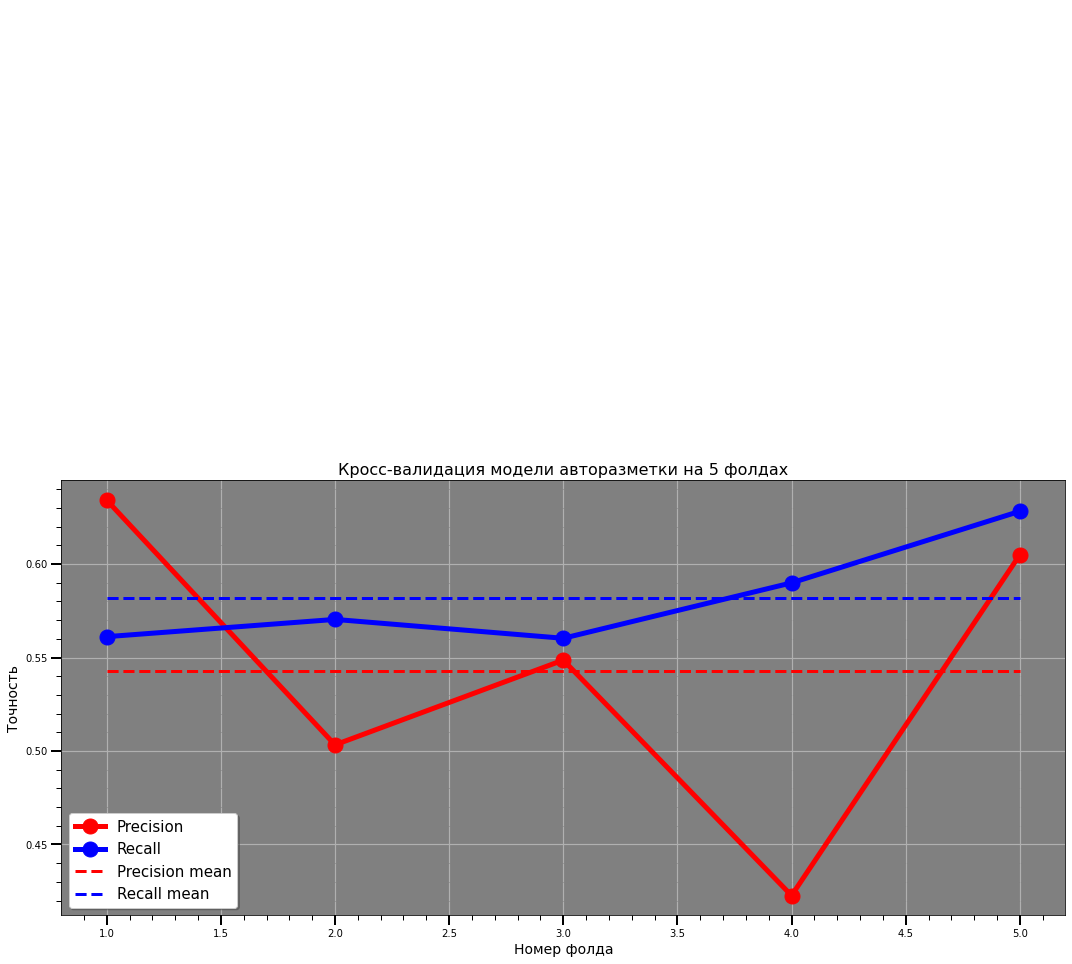

In [8]:
# plt.plot(df.index, df.precision, df.index, df.recall)
# plt.title("Кросс-валидация модели авторазметки на 10 фолдах", fontsize=16) # заголовок
# plt.xlabel("Номер фолда", fontsize=16) # ось абсцисс
# plt.ylabel("Точность", fontsize=14)
# plt.grid(which="major", linewidth=1.2)
# plt.grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
df['precision_mean'] = df.precision.mean()
df['recall_mean'] = df.recall.mean()

fig, ax = plt.subplots(figsize=(18, 8))

fig.set(facecolor = 'w')
ax.set(facecolor = 'grey')

ax.set_title("Кросс-валидация модели авторазметки на 5 фолдах", fontsize=16)
ax.set_xlabel("Номер фолда", fontsize=14)        
ax.set_ylabel("Точность", fontsize=14)

ax.grid(which="major", linewidth=1.2)
ax.grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
ax.plot(df.index+1, df.precision, color="red", label="Precision", linewidth = 5, marker = 'o', markersize=15)
ax.plot(df.index+1, df.recall, color ='blue', label="Recall", linewidth = 5, marker = 'o', markersize=15)
ax.plot(df.index+1, df.precision_mean, color="red", label="Precision mean", linewidth = 3, linestyle = '--')
ax.annotate(round(df.recall.mean(), 2), xy=(5, 0.89), fontsize = 20)
ax.plot(df.index+1, df.recall_mean, color='blue', label="Recall mean", linewidth = 3, linestyle = '--')
ax.annotate(round(df.precision.mean(), 2), xy=(5, 0.78), fontsize = 20)
ax.legend(shadow = True, fontsize = 15)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='major', length=10, width=2)
ax.tick_params(which='minor', length=5, width=1)

plt.show()